# Problem 1

I propose the following algorithm: 

1. generate all the spanning trees ($n ^ {n - 2}$ trees for n nodes)
2. take one proportional to the weight
3. add random edge
4. delete random edge in a cycle
5. if the weight differs less then tol -> finish
6. go to 1.

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt 
import scipy as sp
import scipy.stats

plt.style.use('ggplot')

%matplotlib inline

def draw_graph(G, show_edges_labels = True):
    plt.figure(figsize = (15, 10))
    plt.axis('off')

    pos = nx.circular_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size = 4000)
    nx.draw_networkx_edges(G, pos)
    
    if show_edges_labels:
        labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels = labels)
    
    labels = {}

    for node in G.nodes():
        labels[node] = str(node)
        
    nx.draw_networkx_labels(G, pos, labels = labels)

In [2]:
from itertools import combinations

def generate_spannings(N, weights):
    trees = []
    
    for edges in list(combinations(list(combinations(np.arange(N), 2)), N - 1)):
        g = nx.Graph()

        for v1, v2 in edges:
            g.add_edge(v1, v2, {'weight' : weights[v1, v2]})

        if len(nx.cycle_basis(g)) == 0:
            trees.append(g)
            
    return trees

def compute_sum_cost(graph):
    cost = 0

    for v1, v2 in graph.edges():
        cost += graph.get_edge_data(v1, v2)['weight']
        
    return cost

def compute_mul_cost(graph):
    cost = 1

    for v1, v2 in graph.edges():
        cost *= graph.get_edge_data(v1, v2)['weight']
        
    return cost

uniform sampled tree cost is: 1.7557645798601083
average selected spanning tree cost is: 1.7684158014007554


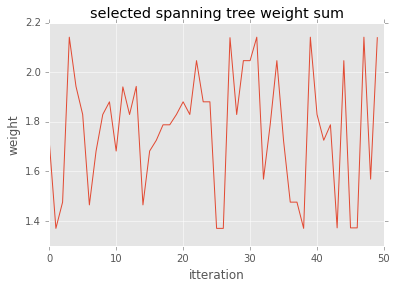

In [3]:
N = 4
itterations = 50
weights = np.random.random(N**2).reshape(N, N)
weights = (weights + weights.T) / 2
weights -= np.eye(N) * weights

def bruteforce(N, weights, itterations):
    spanning_trees = generate_spannings(N, weights)
    average_costs = []

    costs = [0] * len(spanning_trees)

    for index, tree in enumerate(spanning_trees):
        costs[index] = compute_sum_cost(tree)
        
    print('uniform sampled tree cost is: {0}'.format(np.array(costs).mean()))
        
    for i in range(itterations):
        distribution = sp.stats.rv_discrete(values=(np.arange(len(costs)), costs / sum(costs)))
        tree_number = distribution.rvs(size = 1)[0] - 1

        tree = spanning_trees[tree_number]
        average_costs.append(compute_sum_cost(tree))

        v1 = np.random.choice(tree.nodes())
        v2 = np.random.choice(tree.nodes())

        while tree.has_edge(v1, v2) or v1 == v2:
            v1 = np.random.choice(tree.nodes())
            v2 = np.random.choice(tree.nodes())

        tree.add_edge(v1, v2, {'weight' : weights[v1, v2]})
        cycle = nx.cycle_basis(tree)[0]
        edges = []

        for v1, v2 in tree.edges():
            if v1 in cycle and v2 in cycle:
                edges.append((v1, v2))

        edge_to_remove = edges[np.random.choice(np.arange(len(edges)))]
        tree.remove_edge(edge_to_remove[0], edge_to_remove[1])

        costs[tree_number] = compute_sum_cost(tree)

        spanning_trees[tree_number] = tree
        
    plt.plot(average_costs)
    plt.title('selected spanning tree weight sum')
    plt.xlabel('itteration')
    plt.ylabel('weight')
    print('average selected spanning tree cost is: {0}'.format(np.array(average_costs).mean()))
    
bruteforce(N, weights, itterations)

uniform sampled tree cost is: 0.13193999975690437
average spanning tree cost is: 0.15271412944068316


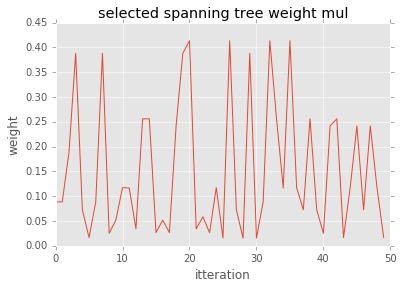

In [119]:
N = 4
itterations = 50
weights = np.random.random(N**2).reshape(N, N)
weights = (weights + weights.T) / 2
weights -= np.eye(N) * weights

def bruteforce(N, weights, itterations):
    spanning_trees = generate_spannings(N, weights)
    average_costs = []

    costs = [0] * len(spanning_trees)

    for index, tree in enumerate(spanning_trees):
        costs[index] = compute_mul_cost(tree)
        
    print('uniform sampled tree cost is: {0}'.format(np.array(costs).mean()))
#     print('гипотиза = {}'.format((weights + np.ones(N)).prod() / N))
        
    for i in range(itterations):
        distribution = sp.stats.rv_discrete(values=(np.arange(len(costs)), costs / sum(costs)))
        tree_number = distribution.rvs(size = 1)[0] - 1

        tree = spanning_trees[tree_number]
        average_costs.append(compute_mul_cost(tree))

        v1 = np.random.choice(tree.nodes())
        v2 = np.random.choice(tree.nodes())

        while tree.has_edge(v1, v2) or v1 == v2:
            v1 = np.random.choice(tree.nodes())
            v2 = np.random.choice(tree.nodes())

        tree.add_edge(v1, v2, {'weight' : weights[v1, v2]})
        cycle = nx.cycle_basis(tree)[0]
        edges = []

        for v1, v2 in tree.edges():
            if v1 in cycle and v2 in cycle:
                edges.append((v1, v2))

        edge_to_remove = edges[np.random.choice(np.arange(len(edges)))]
        tree.remove_edge(edge_to_remove[0], edge_to_remove[1])

        costs[tree_number] = compute_mul_cost(tree)

        spanning_trees[tree_number] = tree
        
    plt.plot(average_costs)
    plt.title('selected spanning tree weight mul')
    plt.xlabel('itteration')
    plt.ylabel('weight')
    print('average spanning tree cost is: {0}'.format(np.array(average_costs).mean()))
    
bruteforce(N, weights, itterations)

The average spanning tree weight estimated by unifrom sampling is $\frac{\sum_{trees}\sum_{tree_edges} edge_{weight}}{N^{N-2}}$ for sum weight and $\frac{\sum_{trees}\prod_{tree_edges} edge_{weight}}{N^{N-2}}$ for mul weight.

The algorithm above is a brute force algorithm

A mcmc algorithm is the following:

1. Start from mimimum spaning tree (it is easy to obtain (ready algorithm) and it has the same probability to be selected randomly as all the other spanning trees).
2. Select node to remove randomly. (Now you have two connected components)
3. Generate all variants to connect this two components.
4. Assign the weight for every tree in a set.
5. Sample with weight

The estimations for the average tree weight are the follosing:

For sum weights $$ E \left(\sum_{e \in tree} c_e \right) = E \left(\sum_{e} c_e I(e \in tree) \right) = \sum_{e} c_e E \left(I(e \in tree) \right) = \sum_{e} c_e p(e \in tree) = \frac{2}{N} \sum_{e} c_e $$
For prod weights $$ E \left(\prod_{e \in tree} c_e \right) = E \left(\prod_{e} c_e I(e \in tree) \right) $$

In [24]:
import itertools

def build_candidates(tree, weight, w, weight_op):
    v1, v2 = tree.edges()[np.random.choice(np.arange(len(tree.edges())))]
    
    if weight_op == 'sum':
        weights = [weight - w[v1, v2]]
    elif weight_op == 'prod':
        weights = [weight / w[v1, v2]]
    else:
        raise RuntimeError('wrong operation')
        
    tree.remove_edge(v1, v2)
    cc1, cc2 = list(nx.connected_components(tree))
    edges_to_add = list(itertools.product(cc1, cc2))
    weights *= len(edges_to_add)
    candidates = [None] * len(edges_to_add)
    
    for i, edge in enumerate(edges_to_add):
        t = tree.copy()
        t.add_edge(edge[0], edge[1])
        candidates[i] = t
        
        if weight_op == 'sum':
            weights[i] += w[edge[0], edge[1]]
        elif weight_op == 'prod':
            weights[i] *= w[edge[0], edge[1]]
    
    return candidates, weights

def mcmc(N, weights, itterations, weight_op):
    g = nx.Graph(weights)
    tree = nx.minimum_spanning_tree(g)
    
    selected_weghts = []

    if weight_op == 'sum':
        weight = compute_sum_cost(tree)
    elif weight_op == 'prod':
        weight = compute_mul_cost(tree)
    else:
        raise RuntimeError('wrong operation')
    
    for i in range(itterations):
        candidates, w  = build_candidates(tree, weight, weights, weight_op)
        distribution = sp.stats.rv_discrete(values=(np.arange(len(candidates)), weights / sum(weights)))
        tree_number = distribution.rvs(size = 1)[0] - 1
        tree = candidates[tree_number]
        weight = w[tree_number]
        selected_weghts.append(weight)
        
    return selected_weghts

In [29]:
np.array(mcmc(N, weights, itterations, 'sum')).mean()

1.7376858209859705

In [30]:
np.array(mcmc(N, weights, itterations, 'prod')).mean()

0.21375553284286777

# Problem 2

First we want to reconstruct the path with the greates information: 

It is the path between nodes $x_2$ and $x_3$.

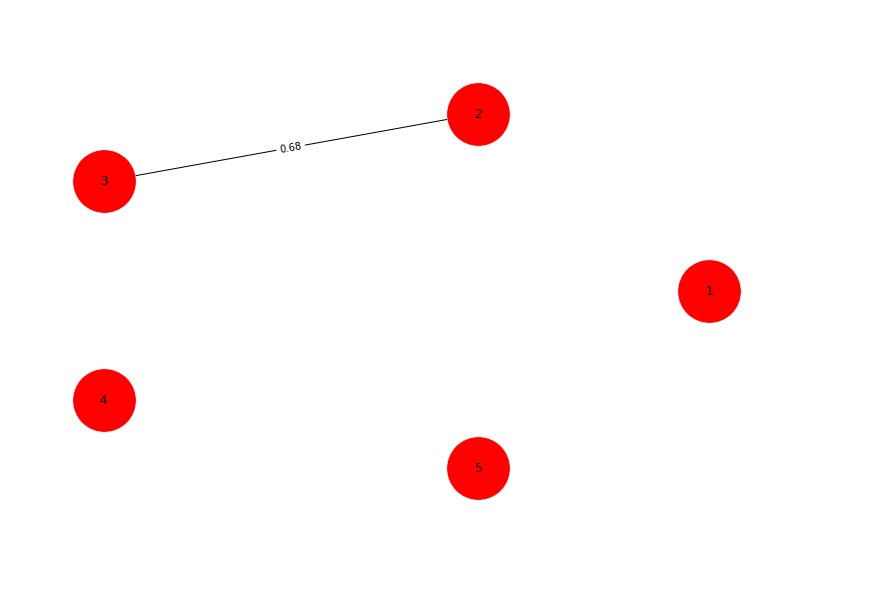

In [2]:
g = nx.Graph()

for i in range(5):
    g.add_node(i + 1)
    
g.add_edge(2, 3, {'weight' : 0.68})

draw_graph(g)

The next path by mutual information is between $x_1$ and $x_5$

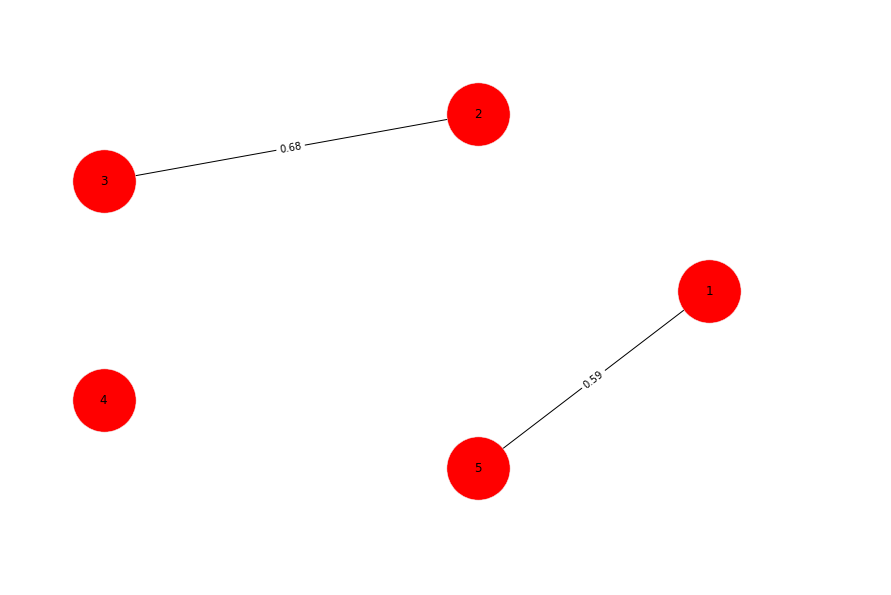

In [3]:
g.add_edge(1, 5, {'weight' : 0.59})

draw_graph(g)

The next one is between $x_1$ and $x_2$.

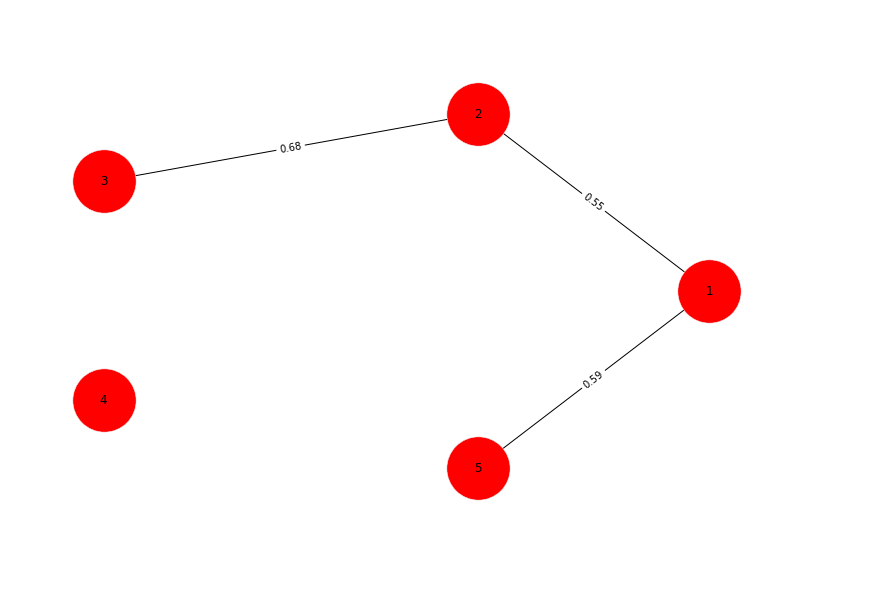

In [4]:
g.add_edge(1, 2, {'weight' : 0.55})

draw_graph(g)

The edge between $x_1$ and $x_3$ adds a loop to the tree thus we ommit it. The same for $x_2$ and $x_5$, $x_3$ and $x_5$. And we have to add just node $x_4$. The maximum information for edge containing $x_4$ is for $x_4$ and $x_1$

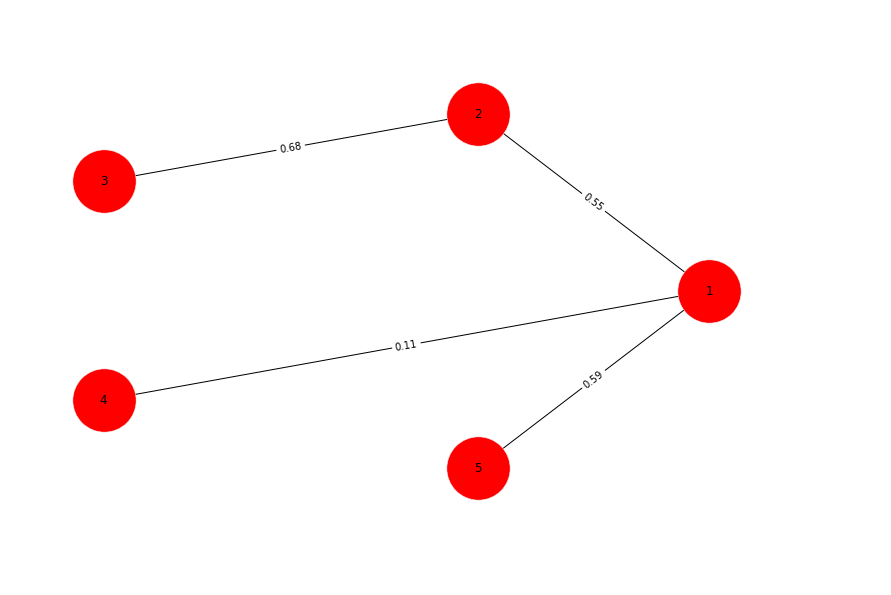

In [5]:
g.add_edge(1, 4, {'weight' : 0.11})

draw_graph(g)

The maximum probable tree has the following view:

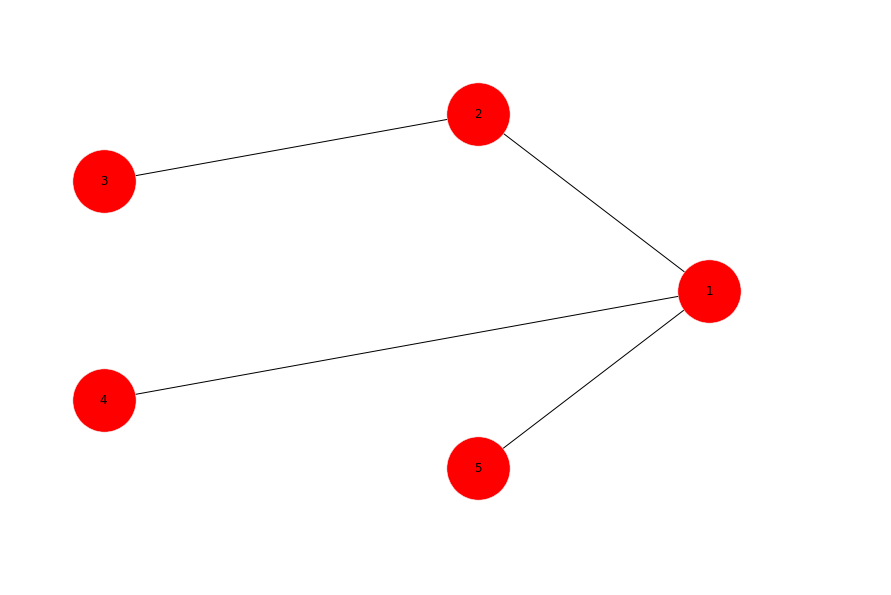

In [7]:
g = nx.Graph()

for i in range(5):
    g.add_node(i + 1)
    
g.add_edge(1, 2)
g.add_edge(1, 4)
g.add_edge(2, 3)
g.add_edge(1, 5)

draw_graph(g)

# Problem 3

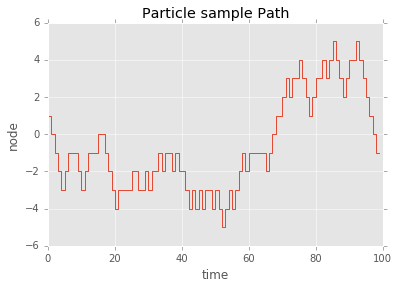

In [17]:
import scipy as sp
import scipy.stats

states = [0]
steps = 100
mu = 0.4
lam = 0.4
left_count = 0
right_count = 0
eps = 1 - mu - lam

jumps = [-1, 0, 1]
distribution = sp.stats.rv_discrete(values=(jumps, [mu, eps, lam]))

assert mu < steps and lam < steps

def next_step(current_state):
    return current_state + distribution.rvs(size = 1)

for i in range(steps):
    states.append(next_step(states[-1]))

plt.title('Particle sample Path')
plt.xlabel('time')
plt.ylabel('node')
plt.step(np.arange(steps), states[:-1])

In [91]:
def p(n, t):
    states = { 0 : { 0 : 1 } }
    
    for i in range(1, t + 1):
        states[i] = {}

        for prev_state, p in states[i - 1].items():
            if prev_state not in states[i]:
                states[i][prev_state] = 0
            if prev_state + 1 not in states[i]:
                states[i][prev_state + 1] = 0
            if prev_state - 1 not in states[i]:
                states[i][prev_state - 1] = 0

            states[i][prev_state] += p * distribution.pmf(0)
            states[i][prev_state - 1] += p * distribution.pmf(-1)
            states[i][prev_state + 1] += p * distribution.pmf(1)
            
    if t == 0 and n == 0:
        return 1
    
    if t == 1:
        if n in [-1, 0, 1]:
            return distribution.pmf(n)
        else:
            return 0

    time_slice = states[t]

    if n not in time_slice:
        return 0
    
    s = 0

    for state, c in time_slice.items():
        s += c
  
    return time_slice[n] / (s - time_slice[n])

In [92]:
p(1, 2)

0.19047619047619044

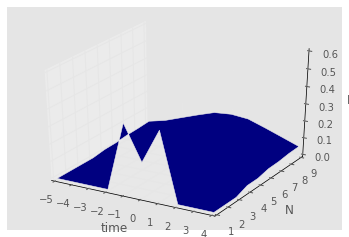

In [100]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
Y, X = np.meshgrid(np.arange(1, 10), np.arange(-5, 5, 1))
zs = np.array([p(x,y) for x, y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z)

ax.set_xlabel('time')
ax.set_ylabel('N')
ax.set_zlabel('P')

plt.show()

$$ \frac{\partial P(n, t)}{\partial t} = - (\alpha + \mu) P(n, t) + \mu P(n + 1, t) + \lambda P(n - 1, t) $$

$$ P(n, 0) = \delta (n) $$

Let us define $$ P(n,t) = \sum _{k = -N}^N f(k,t) e^{\frac{-2\pi i}{2N+1}kn} $$

$$\sum _{k = -N}^N \frac{ \partial f(k,t)}{\partial t}e^{\frac{-2\pi i}{2N+1}kn} = - (\lambda + \mu)\sum _{k = -N}^N f(k,t) e^{\frac{-2\pi i}{2N+1}kn} + \mu \sum _{k = -N}^N f(k,t) e^{\frac{-2\pi i}{2N+1} kn} e^{\frac{-2\pi i}{2N+1} k} + \lambda \sum _{k = -N}^N f(k,t) e^{\frac{-2\pi i}{2N+1}kn}e^{\frac{2\pi i}{2N+1}k} $$
Let us define $$ \alpha = e^{\frac{-2\pi i}{2N+1}} $$
$$\frac{ \partial f(k,t)}{\partial t} = f(- (\lambda + \mu) + \mu  \alpha^k + \lambda \alpha^{-k})$$
Because of zero initial conditions:
$$ f = e^{t(- (\lambda + \mu) + \mu  \alpha^k + \lambda \alpha^{-k})} $$
And put this in the solution: $$P(n,t) = \frac{1}{2N+1}\sum _{k = -N}^N e^{(- (\lambda + \mu) + \mu  \alpha^k + \lambda \alpha^{-k} ) t} e^{\frac{-2\pi i}{2N+1}kn}  $$

n becomes x - continuous variable. The distanse between n and (n+1) is h.
$$P_t(x,t) = \mu P(x+h,t) - 2\mu P(x,t) + \mu P(x-h,t) + (\lambda - \mu)P(x-h,t) - (\lambda - \mu) P(x,t)$$
That is equal to:
$$\frac{\partial P(x,t)}{\partial t} = \mu \frac{\partial^2 P(x,t)}{\partial x^2} + (\lambda - \mu)\frac{\partial P(x,t)}{\partial x}$$
Let us define:
$$ P(x,t) = \frac{1}{2\pi}\int_{-\infty}^{\infty} f(y,t) e^{ixy} dy $$
$$\frac{1}{2\pi}\int_{-\infty}^{\infty} \frac{\partial f(y,t)}{\partial t} e^{ixy} dy = - \mu\frac{1}{2\pi} \int_{-\infty}^{\infty} y^2 f(y,t) e^{ixy} dy + (\lambda - \mu) \frac{1}{2\pi} \int_{-\infty}^{\infty} i y f(y,t) e^{ixy} dy$$
$$\frac{\partial f(x, t)}{\partial t} = -y^2 \mu f + iy (\lambda - \mu) f$$
$$f =  e^{(-y^2 \mu + iy(\lambda - \mu))t} $$
$$P(x,t) =  \frac{1}{2\pi}\int_{-\infty}^{\infty} e^{(-y^2 \mu + iy(\lambda - \mu))t} e^{ixy} dy$$

When $\lambda = 0$
$$P(n,t) = \frac{1}{2N+1}\sum _{k = -N}^N e^{\mu (\alpha^k - 1) t} e^{\frac{-2\pi i}{2N+1}kn} $$

# Problem 4

It is known that:
$$ \partial_t n = D \partial^2_{xx}n − \alpha n $$

S.T.

\begin{cases}
    n(x, 0) = \delta(x - x_0)\\
    n(0, t) =  0\\
    n(L, t) = 0
\end{cases}

Now let us define $$ n(x, t) = \sum_{k=1}^{\infty} a_k(t) sin \left( \frac{\pi k x}{L} \right) $$

Let's rewrite the first equation in a new form:

$$ \sum_{k=1}^{\infty} \frac{\partial a_k(t)}{\partial t} sin \left( \frac{\pi k x}{L} \right) = - \frac{D \pi^2}{L^2} \sum_{k=1}^{\infty} k^2 a_k(t) sin \left( \frac{\pi k x}{L} \right) − \alpha \sum_{k=1}^{\infty} a_k(t) sin \left( \frac{\pi k x}{L} \right) $$

Next let's derrive the equation for $a_k(t)$:

$$ \partial_t a_k(t) = - \frac{D \pi^2 k^2}{L^2} a_k(t) - \alpha a_k(t)  $$

Hence 

$$ a_k(t) = C_k e^{ - \left( \frac{D \pi^2 k^2}{L^2} + \alpha \right) t} $$

$$ n(x, 0) = \sum_{k=1}^{\infty} a_k(0) sin \left( \frac{\pi k x}{L} \right) = \delta(x - x_0) $$

Thus $$ C_k = \frac{2}{L} \int_{0}^{L} \delta(x - x_0) sin \left( \frac{\pi k x}{L} \right) = \frac{2}{L}  sin \left( \frac{\pi k x_0}{L} \right) $$

Finally:

$$ n(x, t) = \frac{2}{L}  \sum_{k=1}^{\infty} sin \left( \frac{\pi k x_0}{L} \right) e^{ - \left( \frac{D \pi^2 k^2}{L^2} + \alpha \right) t} sin \left( \frac{\pi k x}{L} \right) $$

$$ P(x) = \int_{0}^{L} n(x, t) dx = \frac{2}{L}  \sum_{k=1}^{\infty} sin \left( \frac{\pi k x_0}{L} \right) e^{ - \left( \frac{D \pi^2 k^2}{L^2} + \alpha \right) t} \int_{0}^{L} sin \left( \frac{\pi k x}{L} \right) dx  $$

$$ \int_{0}^{L} sin \left( \frac{\pi k x}{L} \right) dx = - \frac{L}{\pi k} cos \left( \frac{\pi k x}{L} \right) |_{0}^{L} = - \frac{L}{\pi k} (1 - cos \left( \pi k \right)) = - \frac{L}{\pi k} (1 - (-1)^k) $$

$$ P(x) = \frac{4}{\pi}  \sum_{k=0}^{\infty} \frac{1}{2k + 1} sin \left( \frac{\pi (2k + 1) x_0}{L} \right) e^{ - \left( D\left( \frac{\pi(2k + 1)}{L} \right) ^2 + \alpha \right) t} $$

L = 1
$x_0 = 0.5$
D = 1
$\alpha = 1$


$$ ET = \int_{0}^{\infty} t p(t) dt $$

$$ p(T) = - \frac{dP(t)}{dt} \big |_{t = T} = - \frac{4}{\pi}  \sum_{k=0}^{\infty} \frac{1}{2k + 1} sin \left( \frac{\pi (2k + 1) x_0}{L} \right) \left( D \left(\frac{\pi(2k + 1)}{L} \right)^2 + \alpha \right) e^{ - \left( D \left( \frac{\pi(2k + 1)}{L} \right)^2 + \alpha \right) T} = \\
= - \frac{4}{\pi}  \sum_{k=0}^{\infty} \frac{ \pi^2 (2k + 1)^2 + 1 }{2k + 1} sin \left( \pi (2k + 1) x_0 \right) e^{ - \left( \pi^2 (2k + 1)^2 + 1 \right) T} $$

$$ ET = - \frac{4}{\pi} \sum_{k=0}^{\infty} \frac{ \pi^2 (2k + 1)^2 + 1 }{2k + 1} sin \left( \pi (2k + 1) x_0 \right)  \int_{0}^{\infty} t e^{ - \left( \pi^2 (2k + 1)^2 + 1 \right) t} dt $$

$$ \int_{0}^{\infty} t e^{ - \left( \pi^2 (2k + 1)^2 + 1 \right) t} dt = |^\% u = t, dv = e^{ - \left( \pi^2 (2k + 1)^2 + 1 \right) T} dt\\ du = dt, v = - \frac{1}{\left( \pi^2 (2k + 1)^2 + 1 \right)} e^{ - \left( \pi^2 (2k + 1)^2 + 1 \right) t} |_\% = - \frac{1}{\left( \pi^2 (2k + 1)^2 + 1 \right)} e^{ - \left( \pi^2 (2k + 1)^2 + 1 \right) t} |_{0}^{\infty} + \int_{0}^{\infty} \frac{1}{\left( \pi^2 (2k + 1)^2 + 1 \right)} e^{ - \left( \pi^2 (2k + 1)^2 + 1 \right) t} dt = \\
= - \frac{1}{(\pi^2 (2k + 1)^2 + 1)} - \frac{1}{\left( \pi^2 (2k + 1)^2 + 1 \right)} \int_{0}^{\infty} e^{ - \left( \pi^2 (2k + 1)^2 + 1 \right) t} dt = - \frac{1}{(\pi^2 (2k + 1)^2 + 1)} - \frac{e^{ - \left( \pi^2 (2k + 1)^2 + 1 \right) t} |_0^\infty}{\left( \pi^2 (2k + 1)^2 + 1 \right)^2} = - \frac{1}{\pi^2 (2k + 1)^2 + 1} \left( 1 +  \frac{1}{\pi^2 (2k + 1)^2 + 1 } \right) $$

$$ ET = \frac{4}{\pi} \sum_{k=0}^{\infty} \frac{ \pi^2 (2k + 1)^2 + 1 }{2k + 1} sin \left( \pi (2k + 1) x_0 \right) \frac{1}{\pi^2 (2k + 1)^2 + 1} \left( 1 +  \frac{1}{\pi^2 (2k + 1)^2 + 1 } \right) = \frac{4}{\pi} \sum_{k=0}^{\infty} \frac{ 1}{2k + 1} sin \left( \pi (2k + 1) x_0 \right)\left( 1 +  \frac{1}{\pi^2 (2k + 1)^2 + 1 } \right) $$

In [23]:
T = 0

for k in range(100000):
    T = T + (1 + 1 / ((np.pi * (2 * k + 1))**2 + 1)) / (2 * k + 1) * np.sin(np.pi * (2 * k + 1) * 0.5)
    
T = T * 4 / np.pi
    
print('ET = {0}'.format(T))

ET = 1.1131779329310665


The probability that absorbtion is before decay is equal to:

$$ 1 - P(T > \frac{1}{\alpha}) $$

$ P(T > \frac{1}{\alpha})$ is exactly survival probability equal to $\frac{4}{\pi}  \sum_{k=0}^{\infty} \frac{1}{2k + 1} sin \left( \frac{\pi (2k + 1) x_0}{L} \right) e^{ - \left( D\left( \frac{\pi(2k + 1)}{L} \right) ^2 + \alpha \right) t} $  with $x_0 = \frac{L}{2}$ 

$$ \partial_x n = \frac{2 \pi}{L^2}  \sum_{k=1}^{\infty} k sin \left( \frac{\pi k x_0}{L} \right) e^{ - \left( \frac{D \pi^2 k^2}{L^2} + \alpha \right) t} cos \left( \frac{\pi k x}{L} \right) $$

$$ J = D \partial_x n $$

$$ P = \int_{0}^{\infty} J dt |_{x = 0} = D \int_{0}^{\infty} \frac{2 \pi}{L^2}  \sum_{k=1}^{\infty} k sin \left( \frac{\pi k x_0}{L} \right) e^{ - \left( \frac{D \pi^2 k^2}{L^2} + \alpha \right) t} cos \left( \frac{\pi k x}{L} \right) dt |_{x = 0} $$ 

$$ P = \frac{2 \pi D}{L^2}  \sum_{k=1}^{\infty} k \ cos \left( \frac{\pi k x}{L} \right) sin \left( \frac{\pi k x_0}{L} \right) \int_{0}^{\infty} e^{ - \left( \frac{D \pi^2 k^2}{L^2} + \alpha \right) t} dt |_{x = 0} = \frac{2 \pi D}{L^2}  \sum_{k=1}^{\infty} k \ cos \left( \frac{\pi k x}{L} \right) sin \left( \frac{\pi k x_0}{L} \right) \frac{-1}{ \left( \frac{D \pi^2 k^2}{L^2} + \alpha \right)} e^{ - \left( \frac{D \pi^2 k^2}{L^2} + \alpha \right) t} |_{0}^{\infty} |_{x = 0} = \\
= -2 \pi D  \sum_{k=1}^{\infty} \frac{k}{ \left( D \pi^2 k^2 + \alpha L^2\right)} \ sin \left( \frac{\pi k x_0}{L} \right)$$ 